In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import our libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from sklearn.
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Import PCA.
from sklearn.decomposition import PCA

In [3]:
# Imports for modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics

In [4]:
combined = pd.read_csv('../../data/combined_kev.csv')

In [5]:
combined.head()

date                 species  wnvpresent  trap   latitude  longitude  \
0  2007-05-29           CULEX PIPIENS           0  T096  41.731922 -87.677512   
1  2007-05-29  CULEX PIPIENS/RESTUANS           0  T086  41.688324 -87.676709   
2  2007-05-29  CULEX PIPIENS/RESTUANS           0  T048  41.867108 -87.654224   
3  2007-05-29  CULEX PIPIENS/RESTUANS           0  T129  41.891126 -87.611560   
4  2007-05-29  CULEX PIPIENS/RESTUANS           0  T050  41.919343 -87.694259   

   species_ord  tmax  tmin  tavg  ...  rel_humid_lag5  rel_humid_lag14  \
0          2.0    88    62    75  ...       59.221367        40.692805   
1          2.0    88    62    75  ...       59.221367        40.692805   
2          2.0    88    62    75  ...       59.221367        40.692805   
3          2.0    88    62    75  ...       59.221367        40.692805   
4          2.0    88    62    75  ...       59.221367        40.692805   

   rel_humid_lag28  avgspeed_lag5  avgspeed_lag14  avgspeed_lag28  \
0        38.885597           7.51        9.682143            10.2   
1        38.885597           7.51        9.682143            10.2   
2        38.885597           7.51        9.682143            10.2   
3        38.885597           7.51        9.682143            10.2   
4        38.885597           7.51        9.682143            10.2   

   preciptotal_lag5  preciptotal_lag14  preciptotal_lag28  week_number  
0              0.15           0.069286           0.055357           22  
1              0.15           0.069286           0.055357           22  
2              0.15           0.069286           0.055357           22  
3              0.15           0.069286           0.055357           22  
4              0.15           0.069286           0.055357           22  

[5 rows x 52 columns]

In [6]:
# convert sunrise & sunset to datetime
sunrise = pd.to_datetime(combined['sunrise'], format='%H%M')
# fix entries - round off 60min to the next hour
sunset = pd.to_datetime(combined['sunset'].map(lambda x: 1800 if x == 1760 else x), format='%H%M')
# convert to seconds from start of day to be consistent input into model
combined['sunrise'] = (sunrise - sunrise.dt.normalize()).dt.seconds
combined['sunset'] = (sunset - sunset.dt.normalize()).dt.seconds
# add total sunlight time feature
combined['total_sunlight_time'] = (sunset - sunrise).dt.seconds

In [7]:
combined.shape

(8475, 53)

In [8]:
pd.set_option('display.max_columns', 500)
combined.head()

date                 species  wnvpresent  trap   latitude  longitude  \
0  2007-05-29           CULEX PIPIENS           0  T096  41.731922 -87.677512   
1  2007-05-29  CULEX PIPIENS/RESTUANS           0  T086  41.688324 -87.676709   
2  2007-05-29  CULEX PIPIENS/RESTUANS           0  T048  41.867108 -87.654224   
3  2007-05-29  CULEX PIPIENS/RESTUANS           0  T129  41.891126 -87.611560   
4  2007-05-29  CULEX PIPIENS/RESTUANS           0  T050  41.919343 -87.694259   

   species_ord  tmax  tmin  tavg  depart  dewpoint  wetbulb  heat  cool  \
0          2.0    88    62    75      11        58       65     0    10   
1          2.0    88    62    75      11        58       65     0    10   
2          2.0    88    62    75      11        58       65     0    10   
3          2.0    88    62    75      11        58       65     0    10   
4          2.0    88    62    75      11        58       65     0    10   

   sunrise  sunset  preciptotal  stnpressure  sealevel  resultspeed  \
0    15660   69420          0.0        29.42      30.1          5.8   
1    15660   69420          0.0        29.42      30.1          5.8   
2    15660   69420          0.0        29.42      30.1          5.8   
3    15660   69420          0.0        29.42      30.1          5.8   
4    15660   69420          0.0        29.42      30.1          5.8   

   resultdir  avgspeed  BC  HZ  DZ  VC  SQ  TS  RA  GR  MI  BR  FU  FG+  FG  \
0         17      6.95   0   1   0   0   0   0   0   0   0   1   0    0   0   
1         17      6.95   0   1   0   0   0   0   0   0   0   1   0    0   0   
2         17      6.95   0   1   0   0   0   0   0   0   0   1   0    0   0   
3         17      6.95   0   1   0   0   0   0   0   0   0   1   0    0   0   
4         17      6.95   0   1   0   0   0   0   0   0   0   1   0    0   0   

   SN  rel_humid  tavg_change  tavg_lag5  tavg_lag14  tavg_lag28  \
0   0  62.733526          3.0       65.2   64.357143   63.428571   
1   0  62.733526          3.0       65.2   64.357143   63.428571   
2   0  62.733526          3.0       65.2   64.357143   63.428571   
3   0  62.733526          3.0       65.2   64.357143   63.428571   
4   0  62.733526          3.0       65.2   64.357143   63.428571   

   rel_humid_lag5  rel_humid_lag14  rel_humid_lag28  avgspeed_lag5  \
0       59.221367        40.692805        38.885597           7.51   
1       59.221367        40.692805        38.885597           7.51   
2       59.221367        40.692805        38.885597           7.51   
3       59.221367        40.692805        38.885597           7.51   
4       59.221367        40.692805        38.885597           7.51   

   avgspeed_lag14  avgspeed_lag28  preciptotal_lag5  preciptotal_lag14  \
0        9.682143            10.2              0.15           0.069286   
1        9.682143            10.2              0.15           0.069286   
2        9.682143            10.2              0.15           0.069286   
3        9.682143            10.2              0.15           0.069286   
4        9.682143            10.2              0.15           0.069286   

   preciptotal_lag28  week_number  total_sunlight_time  
0           0.055357           22                53760  
1           0.055357           22                53760  
2           0.055357           22                53760  
3           0.055357           22                53760  
4           0.055357           22                53760

In [9]:
combined.drop(columns=['date','trap','species'], inplace=True)
combined = combined.drop_duplicates()  #<------ Remove duplicates because species_ord - same

In [10]:
combined.head()

wnvpresent   latitude  longitude  species_ord  tmax  tmin  tavg  depart  \
0           0  41.731922 -87.677512          2.0    88    62    75      11   
1           0  41.688324 -87.676709          2.0    88    62    75      11   
2           0  41.867108 -87.654224          2.0    88    62    75      11   
3           0  41.891126 -87.611560          2.0    88    62    75      11   
4           0  41.919343 -87.694259          2.0    88    62    75      11   

   dewpoint  wetbulb  heat  cool  sunrise  sunset  preciptotal  stnpressure  \
0        58       65     0    10    15660   69420          0.0        29.42   
1        58       65     0    10    15660   69420          0.0        29.42   
2        58       65     0    10    15660   69420          0.0        29.42   
3        58       65     0    10    15660   69420          0.0        29.42   
4        58       65     0    10    15660   69420          0.0        29.42   

   sealevel  resultspeed  resultdir  avgspeed  BC  HZ  DZ  VC  SQ  TS  RA  GR  \
0      30.1          5.8         17      6.95   0   1   0   0   0   0   0   0   
1      30.1          5.8         17      6.95   0   1   0   0   0   0   0   0   
2      30.1          5.8         17      6.95   0   1   0   0   0   0   0   0   
3      30.1          5.8         17      6.95   0   1   0   0   0   0   0   0   
4      30.1          5.8         17      6.95   0   1   0   0   0   0   0   0   

   MI  BR  FU  FG+  FG  SN  rel_humid  tavg_change  tavg_lag5  tavg_lag14  \
0   0   1   0    0   0   0  62.733526          3.0       65.2   64.357143   
1   0   1   0    0   0   0  62.733526          3.0       65.2   64.357143   
2   0   1   0    0   0   0  62.733526          3.0       65.2   64.357143   
3   0   1   0    0   0   0  62.733526          3.0       65.2   64.357143   
4   0   1   0    0   0   0  62.733526          3.0       65.2   64.357143   

   tavg_lag28  rel_humid_lag5  rel_humid_lag14  rel_humid_lag28  \
0   63.428571       59.221367        40.692805        38.885597   
1   63.428571       59.221367        40.692805        38.885597   
2   63.428571       59.221367        40.692805        38.885597   
3   63.428571       59.221367        40.692805        38.885597   
4   63.428571       59.221367        40.692805        38.885597   

   avgspeed_lag5  avgspeed_lag14  avgspeed_lag28  preciptotal_lag5  \
0           7.51        9.682143            10.2              0.15   
1           7.51        9.682143            10.2              0.15   
2           7.51        9.682143            10.2              0.15   
3           7.51        9.682143            10.2              0.15   
4           7.51        9.682143            10.2              0.15   

   preciptotal_lag14  preciptotal_lag28  week_number  total_sunlight_time  
0           0.069286           0.055357           22                53760  
1           0.069286           0.055357           22                53760  
2           0.069286           0.055357           22                53760  
3           0.069286           0.055357           22                53760  
4           0.069286           0.055357           22                53760

In [11]:
# Set y to be the quality column.
y = combined['wnvpresent']
# Set X as all other columns.
X = combined.drop(columns='wnvpresent')


# To show off the strength of PCA, we're going to make many, many more features.
pf = PolynomialFeatures(degree=2)
# Fit and transform our X data using Polynomial Features.
X_new = pf.fit_transform(X)


# Train/test split our data.
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.30,
                                                    random_state = 42)

# Instantiate our StandardScaler.
ss = StandardScaler()
# Scale X_train.
X_train = ss.fit_transform(X_train)
# Scale X_test.
X_test = ss.transform(X_test)


# Instantiate PCA.
pca = PCA()
# Fit PCA on the training data.
pca.fit(X_train)
# Transform PCA on the training data.
Z_train = pca.transform(X_train)
# Don't forget to transform the test data!
Z_test = pca.transform(X_test)



In [12]:
Z_train.shape

(4930, 1275)

In [13]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 50 components): {np.round(var_exp[:50],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 50 components): {np.round(cum_var_exp[:50],3)}')

Explained variance (first 50 components): [0.256 0.118 0.093 0.073 0.058 0.045 0.041 0.039 0.032 0.027 0.025 0.023
 0.021 0.017 0.017 0.012 0.011 0.011 0.008 0.007 0.006 0.005 0.005 0.005
 0.004 0.003 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.    0.    0.
 0.    0.   ]

Cumulative explained variance (first 50 components): [0.256 0.374 0.467 0.54  0.597 0.643 0.684 0.723 0.754 0.781 0.806 0.829
 0.85  0.867 0.884 0.896 0.908 0.918 0.927 0.934 0.94  0.946 0.951 0.955
 0.959 0.963 0.966 0.969 0.971 0.974 0.976 0.978 0.979 0.981 0.983 0.984
 0.985 0.986 0.987 0.988 0.989 0.99  0.991 0.991 0.992 0.993 0.993 0.993
 0.994 0.994]


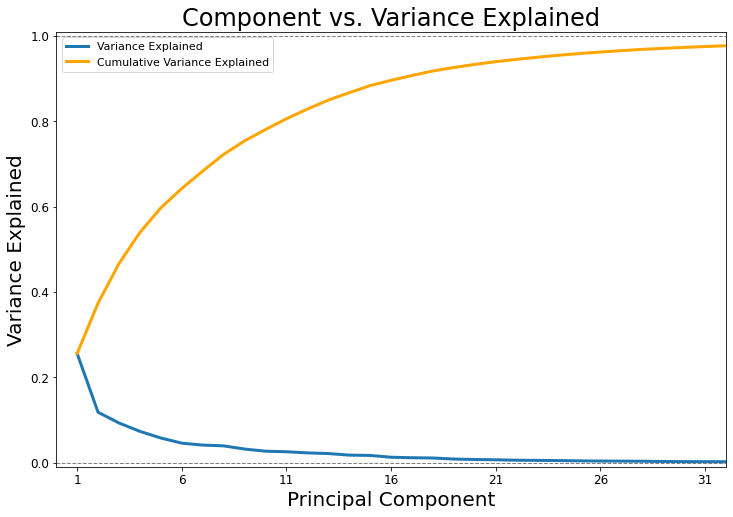

In [14]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,31])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 31, 5), range(1, 32, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

In [15]:
# Go for 50?

Try 10 models for each feature set
 - SVC
 - Log reg
 - Gradient boost

<u>**BASELINE**</u>

1. Assume all '0' - 94.755%
2. Simple lag mode - 94.746%

Training Score: 0.9476  
Testing Score: 0.9475  
F1 Score: 0.0  
ROC_AUC Score: 0.63

In [16]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [17]:
# Instantiate PCA.
pca = PCA(n_components=50)
# Fit PCA on the training data.
pca.fit(X_train)
# Transform PCA on the training data.
Z_train = pca.transform(X_train)
# Don't forget to transform the test data!
Z_test = pca.transform(X_test)

In [56]:
# Instantiate linear regression model.
logreg = LogisticRegression(max_iter=5000, solver='lbfgs')

# Fit on Z_train.
logreg.fit(Z_train,y_train)

# Score on training and testing sets.
print(f'Training Score: {round(logreg.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(logreg.score(Z_test, y_test),4)}')

preds = logreg.predict(Z_test)
preds_proba = logreg.predict_proba(Z_test)[:,1]

print(f'F1 Score: {round(f1_score(y_test, preds),4)}')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, preds_proba),4)}')

Training Score: 0.9422
Testing Score: 0.9418
F1 Score: 0.0465
ROC_AUC Score: 0.8573


In [19]:
ada = AdaBoostClassifier()

ada.fit(Z_train,y_train)

# Score on training and testing sets.
print(f'Training Score: {round(ada.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(ada.score(Z_test, y_test),4)}')

preds = ada.predict(Z_test)
preds_proba = ada.predict_proba(Z_test)[:,1]

print(f'F1 Score: {round(f1_score(y_test, preds),4)}')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, preds_proba),4)}')

Training Score: 0.9432
Testing Score: 0.9413
F1 Score: 0.0
ROC_AUC Score: 0.8405


In [20]:
gb = GradientBoostingClassifier()

gb.fit(Z_train,y_train)

# Score on training and testing sets.
print(f'Training Score: {round(gb.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(gb.score(Z_test, y_test),4)}')

preds = gb.predict(Z_test)
preds_proba = gb.predict_proba(Z_test)[:,1]

print(f'F1 Score: {round(f1_score(y_test, preds),4)}')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, preds_proba),4)}')

Training Score: 0.9487
Testing Score: 0.9375
F1 Score: 0.0704
ROC_AUC Score: 0.8524


In [21]:
clf = SVC(C=1, probability=True)

clf.fit(Z_train,y_train)

# Score on training and testing sets.
print(f'Training Score: {round(clf.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(clf.score(Z_test, y_test),4)}')

preds = clf.predict(Z_test)
preds_proba = clf.predict_proba(Z_test)

print(f'F1 Score: {round(f1_score(y_test, preds),4)}')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, preds),4)}')

Training Score: 0.9428
Testing Score: 0.9418
F1 Score: 0.016
ROC_AUC Score: 0.5036


In [22]:
pd.set_option('display.max_colwidth', None)


# GS

In [23]:
gb = GradientBoostingClassifier()

params = {
    'n_estimators': [1,2,10],
    'max_depth': [2,3,4],
    'learning_rate': [0.1,0.2]
}

gs = GridSearchCV(gb, # what object are we optimizing?
                  params, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.

In [24]:
gs.fit(Z_train,y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [2, 3, 4],
                         'n_estimators': [1, 2, 10]})

In [25]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1}

In [26]:
gs.score(Z_test,y_test)

0.942262186464742

# GS - All Model

In [27]:
# Create DataFrame and write data in
gscv_results = pd.DataFrame(columns=['model','best_params'])

In [28]:
# List of pipeline steps for each model
pipelist = [ 
    [('logreg',LogisticRegression(solver='lbfgs', max_iter=5000))],
    [('ada',AdaBoostClassifier())],
    [('gb',GradientBoostingClassifier())],
    #[('svc',SVC(probability=False))],
    ]

In [29]:
# Name each steps to include in out model
steps_titles = ['logreg',
                'ada',
                'gb',]
                #'svc']

In [30]:
# Set the pipeline parameters
pipe_params = [
    # For logreg
    {'logreg__C': [0.1,1,10]},
    # For AdaBoost
    {'ada__n_estimators': [1,2,5],
    'ada__learning_rate': [0.1,0.2]},
    # For GB
    {'gb__n_estimators': [1,2,5],
    'gb__max_depth': [2,3,4],
    'gb__learning_rate': [0.1,0.2]},
    # For SVC
    #{'svc__kernel': ['rbf', 'linear']}
]

In [31]:
# Loop through our GridSearch and write into our table (gscv_results)
for i in range(len(steps_titles)):     
    pipe = Pipeline(steps=pipelist[i]) 
    gs = GridSearchCV(pipe, pipe_params[i], cv=5) 
    
    # Results for each model (dict)
    model_results = {}

    gs.fit(Z_train, y_train)
    
    # Set each value into temporary dict
    model_results['model'] = steps_titles[i]
    model_results['best_params'] = gs.best_params_
    model_results['train_score'] = round(gs.score(Z_train, y_train),4)
    model_results['test_score'] = round(gs.score(Z_test, y_test),4)
    
    preds = gs.predict(Z_test)
    preds_proba = gs.predict_proba(Z_test)[:,1]
    train_preds_proba = gs.predict_proba(Z_train)[:,1]
    
    #model_results['f1_score'] = round(f1_score(y_test, preds),4)
    #model_results['roc_auc_score'] = round(roc_auc_score(y_test, preds_proba),4)
    
    # Generate a confusion matrix.
    confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.
    
    # Get metrics
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    #model_results['tn'] = tn
    #model_results['fp'] = fp
    #model_results['fn'] = fn
    #model_results['tp'] = tp
    
    model_results['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, train_preds_proba)
    model_results['Test ROC-AUC Score'] = metrics.roc_auc_score(y_test, preds_proba)
    model_results['F1'] = metrics.f1_score(y_test, preds)
    model_results['Precision'] = metrics.precision_score(y_test, preds)
    model_results['Recall'] = metrics.recall_score(y_test, preds)
    model_results['Accuracy'] = metrics.accuracy_score(y_test, preds)
    
    gscv_results = gscv_results.append(model_results, ignore_index=True)

/opt/anaconda3/envs/tensorflowdsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tensorflowdsi/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#gscv_results.to_csv('../../data/mt_model_results.csv')

In [33]:
#gscv_results = pd.read_csv('../../data/mt_model_results.csv')

In [34]:
gscv_results

model  \
0  logreg   
1     ada   
2      gb   

                                                             best_params  \
0                                                       {'logreg__C': 1}   
1                    {'ada__learning_rate': 0.1, 'ada__n_estimators': 1}   
2  {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 1}   

   Accuracy        F1  Precision   Recall  Test ROC-AUC Score  \
0  0.941789  0.046512   0.428571  0.02459            0.857270   
1  0.942262  0.000000   0.000000  0.00000            0.613297   
2  0.942262  0.000000   0.000000  0.00000            0.709379   

   Train ROC-AUC Score  test_score  train_score  
0             0.856750      0.9418       0.9422  
1             0.575874      0.9423       0.9426  
2             0.692264      0.9423       0.9426

In [ ]:
zz

In [117]:
test = pd.read_csv('./prepoly_combined_test.csv')

In [118]:
test.drop(columns=['Unnamed: 0','id'], inplace=True)

In [119]:
test.columns = X.columns
test.columns == X.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [120]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
Xsm, ysm = sm.fit_resample(X, y)

In [121]:
pd.Series(ysm).value_counts()

0    6638
1    6638
Name: wnvpresent, dtype: int64

In [125]:
pf = PolynomialFeatures(degree=2)
train_new = pf.fit_transform(Xsm)
test_new = pf.transform(test)

ss = StandardScaler()
train_new = ss.fit_transform(train_new)
test_new = ss.transform(test_new)

pca = PCA(n_components=50)
train_new_z = pca.fit_transform(train_new)
test_new_z = pca.transform(test_new)

In [126]:
test_new_z.shape

(116293, 50)

In [127]:
train_new_z.shape

(13276, 50)

In [128]:
test_new_z

array([[-1.78737167e+08,  3.48741218e+08,  2.27488095e+08, ...,
        -1.33075479e+08, -3.22683712e+08,  9.33870852e+07],
       [-1.78732564e+08,  3.48735009e+08,  2.27485099e+08, ...,
        -1.33079117e+08, -3.22693895e+08,  9.33762680e+07],
       [-1.78737167e+08,  3.48741218e+08,  2.27488095e+08, ...,
        -1.33075479e+08, -3.22683712e+08,  9.33870852e+07],
       ...,
       [-1.45503489e+08,  2.83872493e+08,  1.85229028e+08, ...,
        -1.08266110e+08, -2.62764239e+08,  7.59194613e+07],
       [-1.45503489e+08,  2.83872493e+08,  1.85229028e+08, ...,
        -1.08266110e+08, -2.62764239e+08,  7.59194613e+07],
       [-1.45503489e+08,  2.83872493e+08,  1.85229028e+08, ...,
        -1.08266110e+08, -2.62764239e+08,  7.59194613e+07]])

In [129]:
# Instantiate our model!
logreg = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.1)

print('Model: ', logreg)

# Fit our model!
lr = logreg.fit(train_new_z,ysm)

Model:  LogisticRegression(C=0.1, max_iter=5000)


In [130]:
kag = pd.read_csv('../../data/test.csv')
# Lowercase columns
kag.columns = [col.lower() for col in kag.columns]

sample = pd.DataFrame()
sample['Id'] = kag['id'].map(lambda x: str(x))
sample['WnvPresent'] = lr.predict_proba(test_new_z)[:,1]

sample.set_index('Id', inplace=True)

sample.to_csv('./sample2.csv')

In [134]:
sample['WnvPresent'].unique()

array([0.])

In [135]:
lr.predict_proba(test_new_z)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [133]:
print(f'Training Score: {round(lr.score(train_new_z, ysm),4)}')
preds_proba1 = lr.predict_proba((train_new_z))[:,1]
metrics.roc_auc_score(ysm, preds_proba1)

Training Score: 0.7911


0.8665316903661944